## Dimensionality reduction practical

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score,jaccard_score,make_scorer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [26]:
with open("ionosphere_names.txt") as text:
    for line in text:
        print(line.rstrip())

1. Title: Johns Hopkins University Ionosphere database

2. Source Information:
   -- Donor: Vince Sigillito (vgs@aplcen.apl.jhu.edu)
   -- Date: 1989
   -- Source: Space Physics Group
              Applied Physics Laboratory
              Johns Hopkins University
              Johns Hopkins Road
              Laurel, MD 20723

3. Past Usage:
   -- Sigillito, V. G., Wing, S. P., Hutton, L. V., \& Baker, K. B. (1989).
      Classification of radar returns from the ionosphere using neural
      networks. Johns Hopkins APL Technical Digest, 10, 262-266.

      They investigated using backprop and the perceptron training algorithm
      on this database.  Using the first 200 instances for training, which
      were carefully split almost 50% positive and 50% negative, they found
      that a "linear" perceptron attained 90.7%, a "non-linear" perceptron
      attained 92%, and backprop an average of over 96% accuracy on the
      remaining 150 test instances, consisting of 123 "good" and onl

## 0. Data preprocessing and visualization

1. Load the "ionosphere.csv" dataset
2. Clean the dataset, remove N/A s, uninformative columns if any
3. Construct and plot inter feature correlation matrice
4. Investigate distributions of each feature(make histogram plots), decide if the dataset needs normalization or not, if yes normalize it
5. Last column is the target column which we will predict. Map (b, g) -> (0, 1)
6. Split the dataset to train/test with 80/20 ratio


In [27]:
#0.1 Load the "ionosphere.csv" dataset
df=pd.read_csv("ionosphere.csv",header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,...,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,g
1,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,...,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,b
2,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,...,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,g
3,1,0,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,...,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,b
4,1,0,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,...,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,g


In [28]:
#0.2 Clean the dataset, remove N/A s, uninformative columns if any
print("\n",df.isnull().sum()>0)

print("\nRow %s is duplicated" % list(df[df.duplicated()==True].index)[0])
df.drop(df[df.duplicated()==True].index,inplace=True)

col=[]
for i in range(1,df.shape[1]+1):
    col.append("COLUMN"+str(i))
df.columns=col
for i in df.columns[:-1]:
    if len(df[i].value_counts())<=2:
        df.drop(i,inplace=True,axis=1)
#0.5 Last column is the target column which we will predict. Map (b, g) -> (0, 1)        
df=df.replace(to_replace="g",value=1)
df=df.replace(to_replace="b",value=0)
df.head()


 0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27    False
28    False
29    False
30    False
31    False
32    False
33    False
34    False
dtype: bool

Row 248 is duplicated


,COLUMN3,COLUMN4,COLUMN5,COLUMN6,COLUMN7,COLUMN8,COLUMN9,COLUMN10,COLUMN11,COLUMN12,...,COLUMN26,COLUMN27,COLUMN28,COLUMN29,COLUMN30,COLUMN31,COLUMN32,COLUMN33,COLUMN34,COLUMN35
0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,0.85243,-0.17755,...,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,1
1,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,0.50874,-0.67743,...,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,0
2,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,0.73082,0.05346,...,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,1
3,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,0.00000,0.00000,...,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,0
4,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,0.52798,-0.20275,...,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,1


In [29]:
#0.3 Construct and plot inter feature correlation matrice
print(abs(df.corr()["COLUMN35"])[df.corr()["COLUMN35"]>0.3])
print()
for j in df.columns[:-1]:
    print("Correlation between %s and %s: %s" % (j,df.columns[-1],df[[j,df.columns[-1]]].corr().iloc[1,0]))

COLUMN3     0.516765
COLUMN5     0.514353
COLUMN7     0.448103
COLUMN35    1.000000
Name: COLUMN35, dtype: float64

Correlation between COLUMN3 and COLUMN35: 0.5167654488294972
Correlation between COLUMN4 and COLUMN35: 0.1258232928837144
Correlation between COLUMN5 and COLUMN35: 0.5143532562365137
Correlation between COLUMN6 and COLUMN35: 0.14852993676752776
Correlation between COLUMN7 and COLUMN35: 0.4481029966142785
Correlation between COLUMN8 and COLUMN35: 0.20721283881862262
Correlation between COLUMN9 and COLUMN35: 0.2921648354659896
Correlation between COLUMN10 and COLUMN35: 0.1195298511859076
Correlation between COLUMN11 and COLUMN35: 0.16526743364518318
Correlation between COLUMN12 and COLUMN35: 0.15917105186743682
Correlation between COLUMN13 and COLUMN35: 0.17978453423808685
Correlation between COLUMN14 and COLUMN35: 0.19683191720571508
Correlation between COLUMN15 and COLUMN35: 0.2057926917482188
Correlation between COLUMN16 and COLUMN35: 0.14856611469890477
Correlation betw

In [30]:
#0.4 Investigate distributions of each feature(make histogram plots), decide if the dataset needs normalization or not, if yes normalize it
df.describe()


,COLUMN3,COLUMN4,COLUMN5,COLUMN6,COLUMN7,COLUMN8,COLUMN9,COLUMN10,COLUMN11,COLUMN12,...,COLUMN26,COLUMN27,COLUMN28,COLUMN29,COLUMN30,COLUMN31,COLUMN32,COLUMN33,COLUMN34,COLUMN35
count,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,...,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000
mean,0.643174,0.044499,0.602785,0.116220,0.551667,0.119701,0.513311,0.181864,0.477543,0.155483,...,-0.071390,0.540331,-0.066879,0.379526,-0.027987,0.353521,-0.003805,0.350362,0.014521,0.642857
std,0.497234,0.442060,0.519608,0.461428,0.492477,0.521456,0.507050,0.484446,0.563725,0.495456,...,0.509208,0.516359,0.548550,0.576353,0.508699,0.571989,0.514310,0.523076,0.469007,0.479843
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,0.473447,-0.065388,0.415473,-0.024868,0.219745,-0.055235,0.093298,-0.049003,0.027873,-0.065677,...,-0.332860,0.283612,-0.428992,0.000000,-0.237083,0.000000,-0.242993,0.000000,-0.166810,0.000000
50%,0.873445,0.016700,0.811145,0.022930,0.729315,0.015085,0.686450,0.020665,0.670560,0.029750,...,-0.015200,0.703345,-0.017685,0.499215,0.000000,0.446875,0.000000,0.413115,0.000000,1.000000
75%,1.000000,0.194727,1.000000,0.335318,0.970445,0.451572,0.954185,0.536192,0.958157,0.483613,...,0.157922,0.999523,0.154862,0.884572,0.154218,0.859490,0.200935,0.816777,0.172105,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [31]:
#0.6 Split the dataset to train/test with 80/20 ratio
from sklearn.model_selection import train_test_split as tts
xtrain , xtest, ytrain, ytest =tts(df[df.columns.difference(["COLUMN35"])],df["COLUMN35"],test_size=0.2,random_state=12)
xtrain.shape ,xtest.shape

((280, 32), (70, 32))

## 1. Classification baseline

Using Logistic Regression of sklearn, run a grid search on parameter C from the values [0.01, 0.1, 1., 10, 100]. Select the best model by running 5 Fold cross validation on train set according to f1 score.

In [32]:
c=  [0.01, 0.1, 1., 10, 100]
max1=0
for i in c:
    log  = LogisticRegression(C=i,solver='liblinear')
    pred = cross_val_score(log,xtrain,ytrain,scoring=make_scorer(f1_score),cv=5,)
    print(pred)
    print("\nFor C = %s the F1_Score(mean of 5 Fold cross validation) is %s "%(i,pred.mean()))
    if pred.mean()>max1:
        max1=pred.mean()
        k=i
        
print("\nThe best model is with C = %s " %k)


[0.8045977  0.875      0.82352941 0.86419753 0.85714286]

For C = 0.01 the F1_Score(mean of 5 Fold cross validation) is 0.8448935001842373 
[0.85365854 0.92105263 0.87179487 0.8974359  0.92307692]

For C = 0.1 the F1_Score(mean of 5 Fold cross validation) is 0.893403772094401 
[0.90909091 0.88888889 0.88311688 0.88311688 0.93506494]

For C = 1.0 the F1_Score(mean of 5 Fold cross validation) is 0.8998556998556999 
[0.88311688 0.84507042 0.85714286 0.89189189 0.94594595]

For C = 10 the F1_Score(mean of 5 Fold cross validation) is 0.8846336001265579 
[0.88311688 0.84507042 0.86842105 0.88888889 0.93150685]

For C = 100 the F1_Score(mean of 5 Fold cross validation) is 0.8834008192975261 

The best model is with C = 1.0 


## 2. Dimensionality Reduction PCA

1. Project data to dimension $K_1$ so that total explained variance ratio is $\geq$0.9
2. Project data to dimension $K_2$ so that total explained variance ratio is $\geq$0.99
3. Train Logistic Regression with the best C from task $\bf 1$ on projected data that you got in $\bf 2.1$ and $\bf 2.2$
4. Compare Jaccard Index and F1 score of the three models.
5. Investigate the learned coefficients of best model that you found in $\bf 1$, make two training sets by selecting $K_1$, $K_2$ most important features.
6. Train Logistic Regression with the best C from task $\bf 1$ on datasets that you made in $\bf 2.5$, and compare Jaccard Index and F1 score with respective models from $\bf 2.3$

In [34]:
#2.1 Project data to dimension  𝐾1  so that total explained variance ratio is  ≥ 0.9
#2.2 Project data to dimension  𝐾2  so that total explained variance ratio is  ≥ 0.99

#pca1 = PCA(n_components=0.9)
#K1= pca1(xtrain)
#K1_test= pca1(xtest)
for i in range (1,xtrain.shape[1]+1):
    pca1 = PCA(n_components=i)#'auto', 'full', 'arpack', 'randomized'
    K1 = pca1.fit_transform(xtrain)
    sum1 = pca1.explained_variance_ratio_.sum()
    if sum1>=0.90:
        K1_test=pca1.fit_transform(xtest)
        print(pca1.explained_variance_ratio_)
        print("\nThe explained_variance_ratio is %s and the n_components = %s" % (sum1,i))
        break

#pca1 = PCA(n_components=0.9)
#K2= pca2(xtrain) 
##K2_test= pca2(xtest)
for i in range (1,xtrain.shape[1]+1):
    pca2 = PCA(n_components=i)
    K2 = pca2.fit_transform(xtrain)
    sum1 = pca2.explained_variance_ratio_.sum()
    if sum1>=0.99:
        K2_test=pca2.fit_transform(xtest)
        
        print("\n\n",pca2.explained_variance_ratio_)
        print("\nThe explained_variance_ratio is %s and the n_components = %s" % (sum1,i))
        break
K1_test.shape,K2_test.shape

from scipy.linalg import svd
cov = xtrain.dot(xtrain.T)/(xtrain.shape[1]-1)
u,s,v = svd(cov)
s.shape

[0.36071873 0.13563987 0.09037006 0.07778065 0.06364355 0.05449194
 0.0362001  0.02733667 0.0267972  0.02179032 0.01699805 0.0154841
 0.01390241 0.01037287 0.0091721  0.00678083 0.00588009 0.00565324]

The explained_variance_ratio is 0.9086391154782942 and the n_components = 18


 [0.36071873 0.13563987 0.09037006 0.07778065 0.06364355 0.05449194
 0.0362001  0.02733667 0.0267972  0.02179032 0.01699805 0.0154841
 0.01390241 0.01037287 0.0091721  0.00678083 0.00588009 0.00565324
 0.00388952 0.00329393 0.00299355 0.0027775  0.00199279 0.00140145
 0.00120278 0.0008624  0.0006401  0.00054728 0.0005362 ]

The explained_variance_ratio is 0.990609059805197 and the n_components = 29


(280,)

In [35]:
#2.3 Train Logistic Regression with the best C from task  1  on projected data that you got in  2.1  and  2.2
#2.4 Compare Jaccard Index and F1 score of the three models.
log = LogisticRegression(C=k,solver='liblinear')
log.fit(xtrain,ytrain)
pred = log.predict(xtest)
print("For the first model f1_score = %s  and jaccard_score = %s " % (round(f1_score(ytest,pred),3),round(jaccard_score(ytest,pred),3))
)

log1 = LogisticRegression(C=k,solver='liblinear')
log1.fit(K1,ytrain)
K1_log = log1.predict(K1_test)
print("\nFor the Second model(K1) f1_score = %s  and jaccard_score = %s " % (round(f1_score(ytest,K1_log),3),round(jaccard_score(ytest,K1_log),3)))

log2 = LogisticRegression(C=k,solver='liblinear')
log2.fit(K2,ytrain)
K2_log = log2.predict(K2_test)
print("\nFor the Third model(K2) f1_score = %s  and jaccard_score = %s " % (round(f1_score(ytest,K2_log),3),round(jaccard_score(ytest,K2_log),3))
)

For the first model f1_score = 0.86  and jaccard_score = 0.754 

For the Second model(K1) f1_score = 0.714  and jaccard_score = 0.556 

For the Third model(K2) f1_score = 0.713  and jaccard_score = 0.554 


In [36]:
#2.5 Investigate the learned coefficients of best model that you found in 1 ,make two training sets by selecting  𝐾1 ,𝐾2  most important features.
d ={}
for i,j in zip(df,log.coef_[0]):
    d[i] = abs(round(j,4))  
d= sorted(d.items(),key=lambda x:x[1],reverse=True)


for i,j in zip(df,log.coef_[0]):
    if abs(j) == max(abs(log.coef_[0])):
        print("\nThe most important feature after Logistic Regression is %s with weight %s" % (i,round(j,4)))
    elif abs(j) == min(abs(log.coef_[0])):
        print("\nThe most unimportant feature after Logistic Regression is %s with weight %s" % (i,round(j,4)))    
print("\nThe importance of features and their absolute value \n\n%s" %d)


def select_most_imp_features(v,df,lk,test=False):
    d={}
    """v: The firs most important k features
       df: data(numpy.ndarray)
       lk: The list of explained_variance_ratio or coefficents"""
    for i,j in zip(list(range(df.shape[0])),lk):
        d[i] = abs(round(j,6))
    a=sorted(d.items(),key=lambda x:x[1],reverse=True)
    b = [i[0] for i in a]
    new_data = df[:,b[:v]]
    if test is False: 
        return new_data
    else:
        return b[:v]
        

K1_selected = select_most_imp_features(12,K1,pca1.explained_variance_ratio_)
K2_selected = select_most_imp_features(18,K2,pca2.explained_variance_ratio_)



The most unimportant feature after Logistic Regression is COLUMN3 with weight -0.0329

The most important feature after Logistic Regression is COLUMN15 with weight -1.9262

The importance of features and their absolute value 

[('COLUMN15', 1.9262), ('COLUMN20', 1.6303), ('COLUMN23', 1.6248), ('COLUMN30', 1.5124), ('COLUMN28', 1.3084), ('COLUMN11', 1.1995), ('COLUMN34', 1.1005), ('COLUMN33', 1.0701), ('COLUMN4', 0.8986), ('COLUMN7', 0.8791), ('COLUMN31', 0.8467), ('COLUMN16', 0.7756), ('COLUMN22', 0.7425), ('COLUMN21', 0.7035), ('COLUMN29', 0.6636), ('COLUMN14', 0.6314), ('COLUMN17', 0.6242), ('COLUMN19', 0.6157), ('COLUMN25', 0.5977), ('COLUMN24', 0.5875), ('COLUMN32', 0.4433), ('COLUMN5', 0.3917), ('COLUMN27', 0.3601), ('COLUMN9', 0.3595), ('COLUMN12', 0.3305), ('COLUMN18', 0.304), ('COLUMN6', 0.3023), ('COLUMN13', 0.3002), ('COLUMN8', 0.2611), ('COLUMN10', 0.2592), ('COLUMN26', 0.0429), ('COLUMN3', 0.0329)]


In [37]:
#2.6 Train Logistic Regression with the best C from task  1  on datasets that you made in  2.5 , and compare Jaccard Index and F1 score with respective models from  2.3
K1_selected_test = K1_test[:,select_most_imp_features(12,K1_test,pca1.explained_variance_ratio_,test=True)]

log_selected1 = LogisticRegression(C=k,solver='liblinear')
log_selected1.fit(K1_selected,ytrain)
K1_selected_pred = log_selected1.predict(K1_selected_test)
print("\nFor the First model with  firs 12 important features f1_score = %s  and jaccard_score = %s " % (round(f1_score(ytest,K1_selected_pred),5),round(jaccard_score(ytest,K1_selected_pred),5)))

print("\nFor the model(K1) f1_score = %s  and jaccard_score = %s " % (round(f1_score(ytest,K1_log),3),round(jaccard_score(ytest,K1_log),3)))




K2_selected_test = K2_test[:,select_most_imp_features(18,K2_test,pca2.explained_variance_ratio_,test=True)]
log_selected2 = LogisticRegression(C=k,solver='liblinear')
log_selected2.fit(K2_selected,ytrain)
K2_selected_pred = log_selected2.predict(K2_selected_test)
print("\n\n\nFor the Second model with  firs 18 important features f1_score = %s  and jaccard_score = %s " % (round(f1_score(ytest,K2_selected_pred),5),round(jaccard_score(ytest,K2_selected_pred),5)))

print("\nFor the  model(K2) f1_score = %s  and jaccard_score = %s " % (round(f1_score(ytest,K2_log),3),round(jaccard_score(ytest,K2_log),3)))


For the First model with  firs 12 important features f1_score = 0.74227  and jaccard_score = 0.59016 

For the model(K1) f1_score = 0.714  and jaccard_score = 0.556 



For the Second model with  firs 18 important features f1_score = 0.71429  and jaccard_score = 0.55556 

For the  model(K2) f1_score = 0.713  and jaccard_score = 0.554 


## 3. Dimensionality Reduction LDA

1. Project data to dimension $K_1$ so that total explained variance ratio is $\geq$0.9
2. Project data to dimension $K_2$ so that total explained variance ratio is $\geq$0.99
3. Train Logistic Regression with the best C from task $\bf 1$ on projected data that you got in $\bf 3.1$ and $\bf 3.2$
4. Compare Jaccard Index and F1 score with the previous models in tasks $\bf 1$ and $\bf 2$.
5. Investigate the learned coefficients of best model that you found in $\bf 1$, make two training sets by selecting $K_1$, $K_2$ most important features.
6. Train Logistic Regression with the best C from task $\bf 1$ on datasets that you made in $\bf 3.5$, and compare Jaccard Index and F1 score with respective models from $\bf 3.3$

In [38]:
#3.1,3.2 Project data to dimension  𝐾1  so that total explained variance ratio is  ≥ 0.9
lda = LDA(n_components=1)
K1 = lda.fit_transform(xtrain,ytrain)
K1_test3 = lda.fit_transform(xtest,ytest)
log = LogisticRegression(C=k,solver="liblinear")
log.fit(K1,ytrain)
K1_pred3 = log.predict(K1_test3)
print("\n\n\nFor the LDA model  f1_score = %s  and jaccard_score = %s " % (round(f1_score(ytest,K1_pred3),5),round(jaccard_score(ytest,K1_pred3),5)))





For the LDA model  f1_score = 0.97959  and jaccard_score = 0.96 


## 4. 2D plots

Make 4 plots
1. Select 2 most important features of the best Logistic Regression model from task $\bf 1$. Make scatter plot using these two features, and color according to target variable.
2. Select first two principal components from task $\bf 2.2$.Make scatter plot using these two components, and color according to target variable.
3. Select first two linear discriminant components from task $\bf 3.2$.Make scatter plot using these two components, and color according to target variable.
4. Project data to 2D space and plot it, again by coloring according to target variable.

[('COLUMN15', 1.9262), ('COLUMN20', 1.6303)]


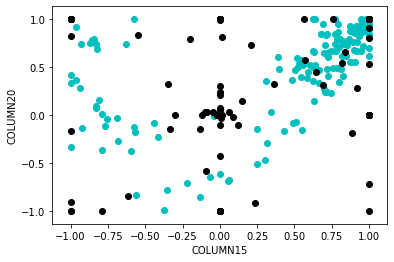

In [39]:
print(d[:2])#2 most important features of the best Logistic Regression model from task  1
plt.xlabel('COLUMN15')
plt.ylabel('COLUMN20')
plt.scatter(df['COLUMN15'].loc[list(ytrain[ytrain==1].index)],df['COLUMN25'].loc[list(ytrain[ytrain==1].index)],c="c")
plt.scatter(df['COLUMN15'].loc[list(ytrain[ytrain==0].index)],df['COLUMN25'].loc[list(ytrain[ytrain==0].index)],color="k")
plt.show()

[0, 1]


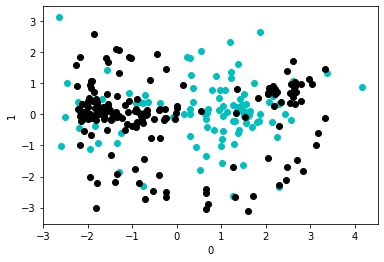

In [40]:
#4.2 Select first two principal components from task  2.2 .Make scatter plot using these two components, and color according to target variable.
l=select_most_imp_features(2,K2,pca2.explained_variance_ratio_,test=True)
print(l)#2 most important features of the best Logistic Regression model from task  2.2(for K2 or K1)
plt.xlabel('0')
plt.ylabel('1')
plt.scatter(K2[:,0][np.where(np.array(ytrain)==0)],K2[:,1][np.where(np.array(ytrain)==0)],c="c")
plt.scatter(K2[:,0][np.where(np.array(ytrain)==1)],K2[:,1][np.where(np.array(ytrain)==1)],color="k")
plt.show()


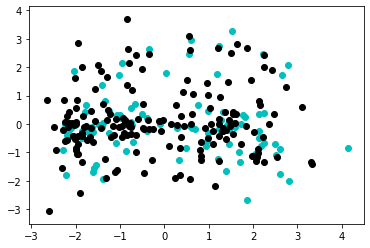

In [41]:
pca = PCA(n_components=2)
D2 = pca.fit_transform(df)
plt.scatter(D2[:,0][np.where(np.array(ytrain)==0)],D2[:,1][np.where(np.array(ytrain)==0)],c="c")
plt.scatter(D2[:,0][np.where(np.array(ytrain)==1)],D2[:,1][np.where(np.array(ytrain)==1)],color="k")